# Using Twitter Emotion Dataset to Fine Tune A Pre-trained Model

In [7]:
# Pretrained model: https://huggingface.co/j-hartmann/emotion-english-distilroberta-base
# Twitter emotion dataset: https://www.kaggle.com/datasets/ankitkumar2635/sentiment-and-emotions-of-tweets

from keras.callbacks import EarlyStopping
from transformers import TFDistilBertForSequenceClassification, DistilBertConfig, DistilBertTokenizer
import pandas as pd
import tensorflow as tf
import re
from sklearn.model_selection import train_test_split


# Load the data and the tokenizer
tweets_df = pd.read_csv("/notebooks/data/emotion_tweets.csv")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def clean_tweet(tweet):
    """Clean the tweet text."""
    tweet = re.sub(r'@\w+', '', tweet)
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)
    return tweet.strip().lower()

# Clean the tweets
tweets_df['cleaned_text'] = tweets_df['Text'].apply(clean_tweet)

# Convert the emotion labels to numerical values
emotion_mapping = {emotion: idx for idx, emotion in enumerate(tweets_df['emotion'].unique())}
tweets_df['emotion_label'] = tweets_df['emotion'].map(emotion_mapping)

# Tokenization
encodings = tokenizer(tweets_df['cleaned_text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors='tf')
labels = tf.convert_to_tensor(tweets_df['emotion_label'].tolist())

# Convert encodings to numpy arrays
input_ids_np = encodings['input_ids'].numpy()
attention_mask_np = encodings['attention_mask'].numpy()

# Split the data
train_encodings_input_ids, val_encodings_input_ids, train_labels, val_labels = train_test_split(input_ids_np, labels.numpy(), test_size=0.2, random_state=42)
train_encodings_attention_mask, val_encodings_attention_mask, _, _ = train_test_split(attention_mask_np, labels.numpy(), test_size=0.2, random_state=42)

# Convert lists back to tensors
train_encodings_input_ids = tf.convert_to_tensor(train_encodings_input_ids)
val_encodings_input_ids = tf.convert_to_tensor(val_encodings_input_ids)
train_encodings_attention_mask = tf.convert_to_tensor(train_encodings_attention_mask)
val_encodings_attention_mask = tf.convert_to_tensor(val_encodings_attention_mask)
train_labels = tf.convert_to_tensor(train_labels)
val_labels = tf.convert_to_tensor(val_labels)


train_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids": train_encodings_input_ids, "attention_mask": train_encodings_attention_mask}, train_labels)).shuffle(1000).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids": val_encodings_input_ids, "attention_mask": val_encodings_attention_mask}, val_labels)).batch(32)

# Define a custom loss function
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)

def custom_loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, -1))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Load DistilBertConfig and adjust dropout rate
config = DistilBertConfig(dropout=0.5, attention_dropout=0.5, num_labels=len(emotion_mapping))
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config)

# Compile the model with the custom loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=custom_loss, metrics=['accuracy'])

# Train the model with early stopping
history = model.fit(train_dataset, validation_data=val_dataset, epochs=30, callbacks=[early_stopping])



Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'activation_13', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_59', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/30
625/625 [==============================] - 34s 45ms/step - loss: 38.5148 - accuracy: 0.5565 - val_loss: 30.4257 - val_accuracy: 0.6532
Epoch 2/30
625/625 [==============================] - 27s 43ms/step - loss: 29.4239 - accuracy: 0.6636 - val_loss: 28.0471 - val_accuracy: 0.6914
Epoch 3/30
625/625 [==============================] - 26s 42ms/step - loss: 26.1389 - accuracy: 0.6989 - val_loss: 29.7736 - val_accuracy: 0.6674
Epoch 4/30
625/625 [==============================] - 26s 42ms/step - loss: 23.5391 - accuracy: 0.7286 - val_loss: 30.0690 - val_accuracy: 0.6770
Epoch 5/30
625/625 [==============================] - 27s 43ms/step - loss: 21.8920 - accuracy: 0.7459 - val_loss: 27.5558 - val_accuracy: 0.7000
Epoch 6/30
625/625 [==============================] - 26s 42ms/step - loss: 20.3042 - accuracy: 0.7691 - val_loss: 30.4666 - val_accuracy: 0.7008
Epoch 7/30
625/625 [==============================] - 27s 42ms/step - loss: 18.9866 - accuracy: 0.7818 - val_loss: 33.0864 -

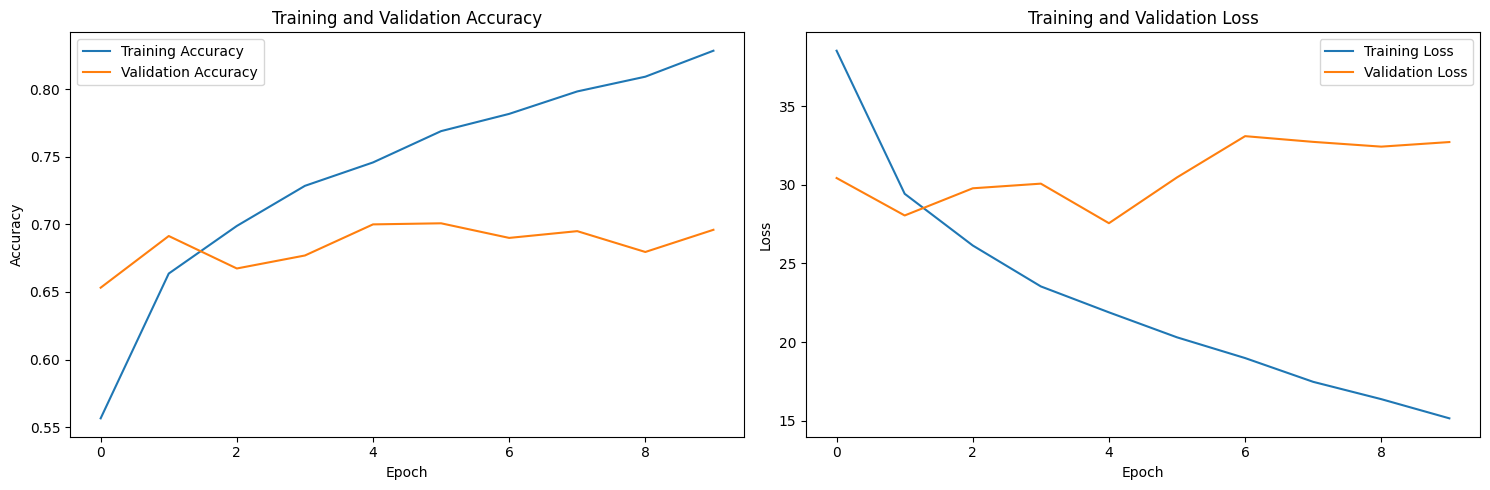

In [8]:
import matplotlib.pyplot as plt

# Extract accuracy and loss from the training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(train_acc, label='Training Accuracy')
ax1.plot(val_acc, label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(train_loss, label='Training Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Show the figure
plt.tight_layout()
plt.show()


157/157 [==============================] - 4s 17ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

anticipation       0.72      0.58      0.64      1037
         joy       0.79      0.79      0.79      1289
       anger       0.80      0.88      0.84      1464
     sadness       0.40      0.48      0.44       240
        fear       0.60      0.69      0.64        68
    optimism       0.52      0.59      0.55       271
     disgust       0.46      0.43      0.44       616
    surprise       0.00      0.00      0.00         9

    accuracy                           0.70      4994
   macro avg       0.54      0.56      0.54      4994
weighted avg       0.70      0.70      0.70      4994



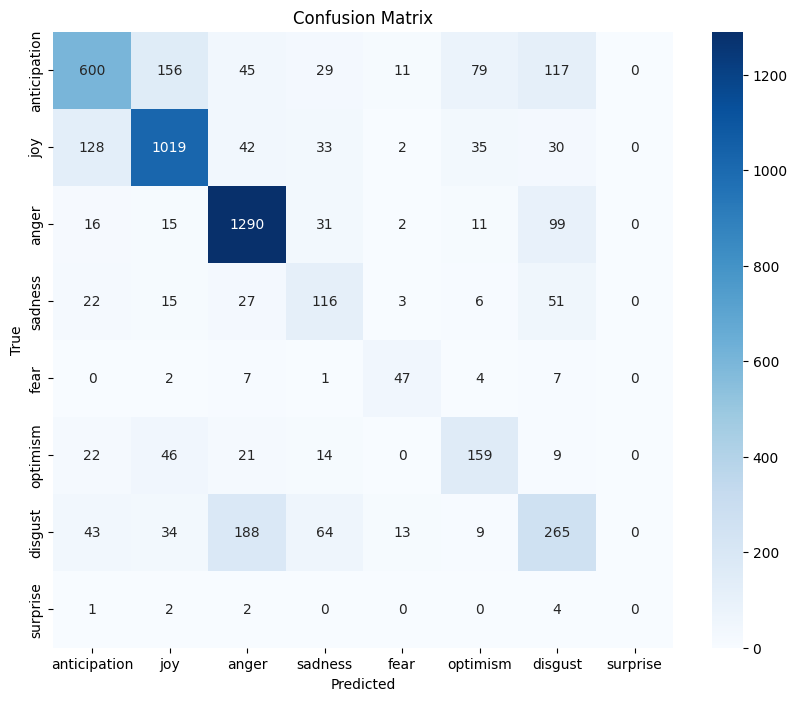

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get model predictions
predictions = model.predict(val_dataset)
y_pred = tf.argmax(predictions.logits, axis=1).numpy()

# Classification report
print("Classification Report:\n", classification_report(val_labels, y_pred, target_names=emotion_mapping.keys()))

# Confusion matrix
conf_matrix = confusion_matrix(val_labels, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=emotion_mapping.keys(), yticklabels=emotion_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Improving the Previous Results by Fine Tuning Different Model on the Same Data

In [12]:
# Model: https://huggingface.co/bhadresh-savani/bert-base-uncased-emotion

from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import re

# 1. Load the data and the tokenizer
tweets_df = pd.read_csv("/notebooks/data/emotion_tweets.csv")

def clean_tweet(tweet):
    """Clean the tweet text."""
    tweet = re.sub(r'@\w+', '', tweet)
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)
    return tweet.strip().lower()

# Clean the tweets
tweets_df['cleaned_text'] = tweets_df['Text'].apply(clean_tweet)

# Convert the emotion labels to numerical values
emotion_mapping = {emotion: idx for idx, emotion in enumerate(tweets_df['emotion'].unique())}
tweets_df['emotion_label'] = tweets_df['emotion'].map(emotion_mapping)

# 2. Tokenize the Data
tokenizer = BertTokenizer.from_pretrained('bhadresh-savani/bert-base-uncased-emotion')
encodings = tokenizer(tweets_df['cleaned_text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors='tf')
labels = tf.convert_to_tensor(tweets_df['emotion_label'].tolist())

# Convert encodings to numpy arrays and split
input_ids_np = encodings['input_ids'].numpy()
attention_mask_np = encodings['attention_mask'].numpy()
train_encodings_input_ids, val_encodings_input_ids, train_labels, val_labels = train_test_split(
    input_ids_np, 
    labels.numpy(), 
    test_size=0.2, 
    random_state=42)

train_encodings_attention_mask, val_encodings_attention_mask, _, _ = train_test_split(
    attention_mask_np, 
    labels.numpy(), 
    test_size=0.2, 
    random_state=42)

# 3. Convert Data to TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids": train_encodings_input_ids, "attention_mask": train_encodings_attention_mask}, train_labels)).shuffle(1000).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids": val_encodings_input_ids, "attention_mask": val_encodings_attention_mask}, val_labels)).batch(32)

# 1. Load the base model
base_model = TFBertForSequenceClassification.from_pretrained('bhadresh-savani/bert-base-uncased-emotion')

# 2. Modify the classifier layer
num_labels = len(emotion_mapping)
base_model.classifier = tf.keras.layers.Dense(num_labels, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02), name="classifier")

# 3. Compile and Fine-tune
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
base_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = base_model.fit(train_dataset, validation_data=val_dataset, epochs=30)



Some layers from the model checkpoint at bhadresh-savani/bert-base-uncased-emotion were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at bhadresh-savani/bert-base-uncased-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Epoch 1/30
625/625 [==============================] - 63s 85ms/step - loss: 0.8859 - accuracy: 0.6796 - val_loss: 0.7653 - val_accuracy: 0.7199
Epoch 2/30
625/625 [==============================] - 51s 82ms/step - loss: 0.4982 - accuracy: 0.8182 - val_loss: 0.8303 - val_accuracy: 0.7209
Epoch 3/30
625/625 [==============================] - 51s 82ms/step - loss: 0.2895 - accuracy: 0.9011 - val_loss: 1.0224 - val_accuracy: 0.6908
Epoch 4/30
625/625 [==============================] - 51s 82ms/step - loss: 0.1846 - accuracy: 0.9387 - val_loss: 1.0651 - val_accuracy: 0.7273
Epoch 5/30
625/625 [==============================] - 51s 82ms/step - loss: 0.1348 - accuracy: 0.9555 - val_loss: 1.1664 - val_accuracy: 0.7155
Epoch 6/30
625/625 [==============================] - 51s 81ms/step - loss: 0.1016 - accuracy: 0.9669 - val_loss: 1.2412 - val_accuracy: 0.7034
Epoch 7/30
625/625 [==============================] - 51s 81ms/step - loss: 0.0943 - accuracy: 0.9691 - val_loss: 1.3205 - val_accuracy:

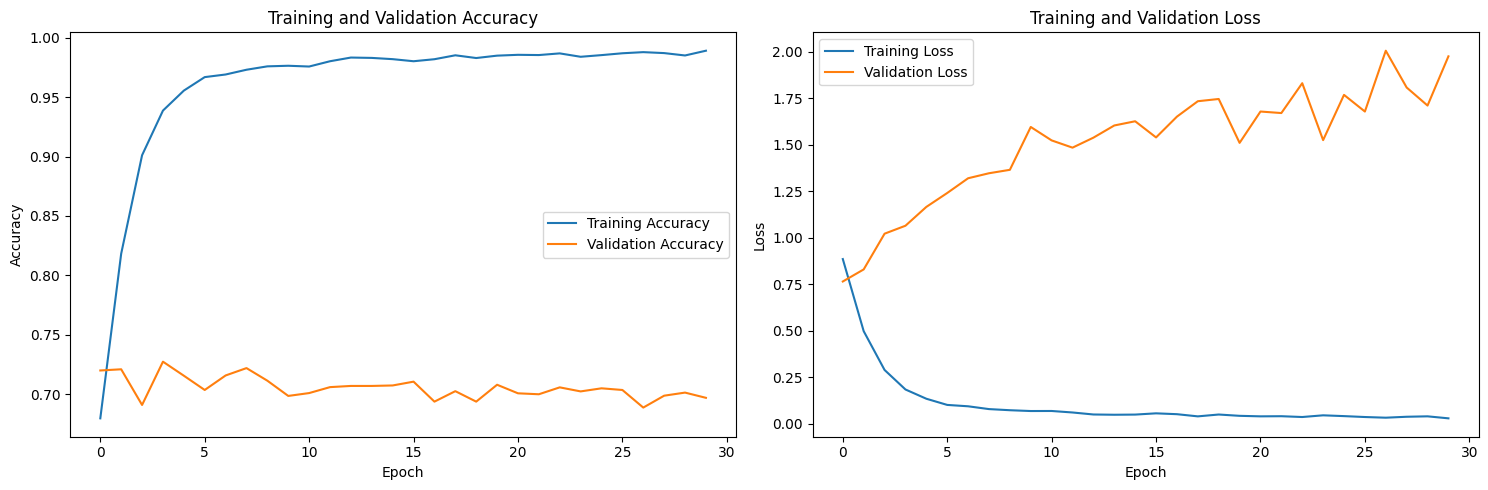

In [13]:
import matplotlib.pyplot as plt

# Extract accuracy and loss from the training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(train_acc, label='Training Accuracy')
ax1.plot(val_acc, label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(train_loss, label='Training Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Show the figure
plt.tight_layout()
plt.show()


157/157 [==============================] - 3s 17ms/step
Classification Report:
               precision    recall  f1-score   support

anticipation       0.72      0.58      0.64      1037
         joy       0.79      0.79      0.79      1289
       anger       0.80      0.88      0.84      1464
     sadness       0.40      0.48      0.44       240
        fear       0.60      0.69      0.64        68
    optimism       0.52      0.59      0.55       271
     disgust       0.46      0.43      0.44       616
    surprise       0.00      0.00      0.00         9

    accuracy                           0.70      4994
   macro avg       0.54      0.56      0.54      4994
weighted avg       0.70      0.70      0.70      4994



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


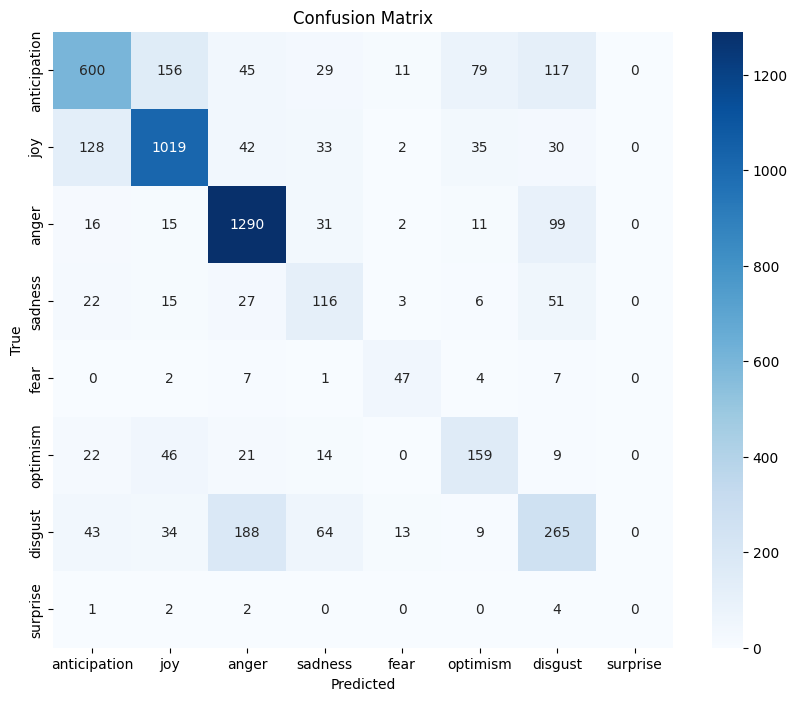

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get model predictions
predictions = model.predict(val_dataset)
y_pred = tf.argmax(predictions.logits, axis=1).numpy()

# Classification report
print("Classification Report:\n", classification_report(val_labels, y_pred, target_names=emotion_mapping.keys()))

# Confusion matrix
conf_matrix = confusion_matrix(val_labels, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=emotion_mapping.keys(), yticklabels=emotion_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [16]:
from keras_tuner import HyperParameters

def build_model(hp: HyperParameters):
    # Use hyperparameters to define values
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # Here you can add other hyperparameters if needed
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    
    # Load the BERT model
    model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(emotion_mapping))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model


In [ ]:
from keras_tuner.tuners import RandomSearch

# Define the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=30,  # Number of different combinations to try
    executions_per_trial=10,  # How many times to run each trial (with different weight initializations)
    directory='random_search',
    project_name='bert_tuning'
)

# Start the search for the best hyperparameters
tuner.search(train_dataset, validation_data=val_dataset, epochs=15, callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])


Trial 7 Complete [00h 29m 03s]
val_accuracy: 0.7100320398807526

Best val_accuracy So Far: 0.7168602347373962
Total elapsed time: 01h 15m 26s

Search: Running Trial #8

Value             |Best Value So Far |Hyperparameter
0.01              |0.0001            |learning_rate
0.4               |0.4               |dropout_rate



All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
625/625 [==============================] - 65s 88ms/step - loss: 2.2327 - accuracy: 0.2435 - val_loss: 1.9418 - val_accuracy: 0.2932
Epoch 2/15
625/625 [==============================] - 52s 83ms/step - loss: 2.2255 - accuracy: 0.2433 - val_loss: 1.9241 - val_accuracy: 0.2076
Epoch 3/15
625/625 [==============================] - 52s 83ms/step - loss: 2.2918 - accuracy: 0.2386 - val_loss: 2.2378 - val_accuracy: 0.1233
Epoch 4/15
625/625 [==============================] - 52s 83ms/step - loss: 2.2681 - accuracy: 0.2483 - val_loss: 2.2705 - val_accuracy: 0.2076


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
625/625 [==============================] - 62s 84ms/step - loss: 2.1912 - accuracy: 0.2436 - val_loss: 2.4592 - val_accuracy: 0.2581
Epoch 2/15
625/625 [==============================] - 51s 82ms/step - loss: 2.2519 - accuracy: 0.2361 - val_loss: 3.0984 - val_accuracy: 0.2581
Epoch 3/15
625/625 [==============================] - 51s 82ms/step - loss: 2.2004 - accuracy: 0.2388 - val_loss: 2.1496 - val_accuracy: 0.2581
Epoch 4/15
625/625 [==============================] - 51s 82ms/step - loss: 2.3045 - accuracy: 0.2414 - val_loss: 2.7074 - val_accuracy: 0.2932
Epoch 5/15
625/625 [==============================] - 51s 82ms/step - loss: 2.1912 - accuracy: 0.2456 - val_loss: 2.3654 - val_accuracy: 0.2932


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
625/625 [==============================] - 63s 86ms/step - loss: 2.2421 - accuracy: 0.2392 - val_loss: 2.3110 - val_accuracy: 0.2932
Epoch 2/15
625/625 [==============================] - 51s 82ms/step - loss: 2.2397 - accuracy: 0.2370 - val_loss: 1.9878 - val_accuracy: 0.2076
Epoch 3/15
625/625 [==============================] - 51s 82ms/step - loss: 2.1957 - accuracy: 0.2388 - val_loss: 1.9949 - val_accuracy: 0.2932
Epoch 4/15
625/625 [==============================] - 51s 82ms/step - loss: 2.1736 - accuracy: 0.2503 - val_loss: 2.3279 - val_accuracy: 0.2076


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
625/625 [==============================] - 63s 86ms/step - loss: 2.2302 - accuracy: 0.2408 - val_loss: 2.3565 - val_accuracy: 0.2932
Epoch 2/15
625/625 [==============================] - 51s 82ms/step - loss: 2.2172 - accuracy: 0.2418 - val_loss: 2.0341 - val_accuracy: 0.1233
Epoch 3/15
625/625 [==============================] - 51s 82ms/step - loss: 2.2288 - accuracy: 0.2354 - val_loss: 2.1986 - val_accuracy: 0.0543
Epoch 4/15
625/625 [==============================] - 51s 82ms/step - loss: 2.2181 - accuracy: 0.2385 - val_loss: 2.3840 - val_accuracy: 0.2932


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
625/625 [==============================] - 63s 85ms/step - loss: 2.2537 - accuracy: 0.2409 - val_loss: 2.0265 - val_accuracy: 0.2581
Epoch 2/15
625/625 [==============================] - 52s 83ms/step - loss: 2.2070 - accuracy: 0.2433 - val_loss: 1.8918 - val_accuracy: 0.2581
Epoch 3/15
625/625 [==============================] - 51s 82ms/step - loss: 2.2802 - accuracy: 0.2399 - val_loss: 2.9660 - val_accuracy: 0.0136
Epoch 4/15
625/625 [==============================] - 52s 82ms/step - loss: 2.2887 - accuracy: 0.2392 - val_loss: 3.0384 - val_accuracy: 0.1233


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
 50/625 [=>............................] - ETA: 43s - loss: 2.0810 - accuracy: 0.2475

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"The optimal learning rate is {best_hps.get('learning_rate')}")
print(f"The optimal Dropout is {best_hps.get('dropout_rate')}")
# ... Similarly for other hyperparameters

best_trial = tuner.get_best_trials(num_trials=1)[0]
print(best_trial.hyperparameters.values)


In [18]:
df.columns

Index(['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id',
       'created_utc', 'rater_id', 'example_very_unclear', 'admiration',
       'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
       'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust',
       'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy',
       'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
       'remorse', 'sadness', 'surprise', 'neutral'],
      dtype='object')